In [1]:
import numpy as np
import xarray as xr
import os
import fnmatch
from tqdm.autonotebook import tqdm
import dask
import gcsfs
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
fs = gcsfs.GCSFileSystem() # equivalent to fsspec.fs('gs')

/tmp/ipykernel_2629/3658017814.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
fs.ls('gs://leap-persistent/timh37/CMIP6/subsetted_data/psl_europe/MPI-ESM1-2-HR_CanESM5_grid')

['leap-persistent/timh37/CMIP6/subsetted_data/psl_europe/MPI-ESM1-2-HR_CanESM5_grid/MPI-ESM1-2-HR_gn_historical_day_r1i1p1f1.zarr',
 'leap-persistent/timh37/CMIP6/subsetted_data/psl_europe/MPI-ESM1-2-HR_CanESM5_grid/MPI-ESM1-2-HR_gn_historical_day_r2i1p1f1.zarr',
 'leap-persistent/timh37/CMIP6/subsetted_data/psl_europe/MPI-ESM1-2-HR_CanESM5_grid/MPI-ESM1-2-HR_gn_ssp245_day_r1i1p1f1.zarr',
 'leap-persistent/timh37/CMIP6/subsetted_data/psl_europe/MPI-ESM1-2-HR_CanESM5_grid/MPI-ESM1-2-HR_gn_ssp245_day_r2i1p1f1.zarr',
 'leap-persistent/timh37/CMIP6/subsetted_data/psl_europe/MPI-ESM1-2-HR_CanESM5_grid/MPI-ESM1-2-HR_gn_ssp585_day_r1i1p1f1.zarr',
 'leap-persistent/timh37/CMIP6/subsetted_data/psl_europe/MPI-ESM1-2-HR_CanESM5_grid/MPI-ESM1-2-HR_gn_ssp585_day_r2i1p1f1.zarr']

In [3]:
fs.ls('gs://leap-persistent/timh37/CMIP6/subsetted_data/sfcWind_europe/MPI-ESM1-2-HR')

['leap-persistent/timh37/CMIP6/subsetted_data/sfcWind_europe/MPI-ESM1-2-HR/MPI-ESM1-2-HR_gn_historical_day_r1i1p1f1.zarr',
 'leap-persistent/timh37/CMIP6/subsetted_data/sfcWind_europe/MPI-ESM1-2-HR/MPI-ESM1-2-HR_gn_historical_day_r2i1p1f1.zarr',
 'leap-persistent/timh37/CMIP6/subsetted_data/sfcWind_europe/MPI-ESM1-2-HR/MPI-ESM1-2-HR_gn_ssp245_day_r1i1p1f1.zarr',
 'leap-persistent/timh37/CMIP6/subsetted_data/sfcWind_europe/MPI-ESM1-2-HR/MPI-ESM1-2-HR_gn_ssp245_day_r2i1p1f1.zarr',
 'leap-persistent/timh37/CMIP6/subsetted_data/sfcWind_europe/MPI-ESM1-2-HR/MPI-ESM1-2-HR_gn_ssp585_day_r1i1p1f1.zarr',
 'leap-persistent/timh37/CMIP6/subsetted_data/sfcWind_europe/MPI-ESM1-2-HR/MPI-ESM1-2-HR_gn_ssp585_day_r2i1p1f1.zarr']

In [4]:
def po_t_of_refyear(da,threshold,refyear,dim):
    return da.where(da>da.sel(window=refyear).quantile(threshold,dim=dim))
            
def rolling_max(da,window_len,dim):
    return da.rolling({dim:window_len},center=True,min_periods=1).max()

def sum_num_extremes_pmonth(extremes):
    extremes_ = extremes.copy(deep=True) #boolean array (True or False joint extreme occurs on that day)
    if len(extremes.time.shape)>1:
        extremes_['time_in_window_idx'] = extremes_.time.dt.month.isel(window=0).values
    else:
        extremes_['time_in_window_idx'] = extremes_.time.dt.month.values
    num_extremes_pmonth = extremes_.rename({'time_in_window_idx':'month'}).groupby('month').sum()
    return num_extremes_pmonth        

Configure the bivariate sampling:

In [5]:
#configure bivariate sampling settings
max_lag = 0 #days
declus_window_len = 1 #days
threshold = .98 #quantile

output_yrs = np.arange(1960,2100,20)
window_len=40 #may need to increase? indicate settings in output folder?

ref_year = 2000 #period to to compute thresholds from

In [6]:
#configure the CMIP6 input settings
var1 = 'surge'
var2 = 'pr'
domain = 'tgs' #'europe' or 'tgs'

var1_dir = 'leap-persistent/timh37/CMIP6/timeseries/'+var1+'_'+domain
var2_dir = 'leap-persistent/timh37/CMIP6/timeseries/'+var2+'_'+domain

if domain == 'tgs':
    input_is_gridded = False
elif domain == 'europe':
    input_is_gridded = True

In [7]:
models_var1 = [k.split('/')[-1] for k in fs.ls(var1_dir)]
models_var2 = [k.split('/')[-1] for k in fs.ls(var2_dir)]
source_ids = sorted(list(set(models_var1) & set(models_var2))) #intersection of models

for source_id in ['MPI-ESM1-2-HR_CanESM5_grid']:#[k for k in source_ids if ~k.startswith('.')]: #loop over models
  
    var1_model_path = os.path.join(var1_dir,'MPI-ESM1-2-HR')
    var2_model_path = os.path.join(var2_dir,'MPI-ESM1-2-HR')
    
    #sfcWind_exps = [s.split('_')[-1][0:-3] for s in os.listdir(sfcWind_path) if s.startswith('.')==False]
    #pr_exps = [s.split('_')[-1][0:-3] for s in os.listdir(pr_path) if s.startswith('.')==False]
    
    #get experiment_id's
    var1_exps = [s.split('/')[-1].split('_')[-1][0:-5] for s in fs.ls(var1_model_path) if s.startswith('.')==False] 
    var2_exps = [s.split('/')[-1].split('_')[-1][0:-5] for s in fs.ls(var2_model_path) if s.startswith('.')==False]
    experiment_ids = list(set(var1_exps) & set(var2_exps))

    for experiment_id in ['ssp585']:#experiment_ids: #loop over experiments
        #load data:
        fn = fnmatch.filter(fs.ls(var1_model_path),'*'+experiment_id+'*')[0]
        fn = fn.split('/')[-1]
        print('Processing file: '+fn)
        if input_is_gridded==False:
            var1_var2_data = xr.open_mfdataset((os.path.join('gs://',var1_model_path,fn),os.path.join('gs://',var2_model_path,fn)),engine='zarr',compat='override',chunks={'member_id':1,'time':100000})
        else:
            #sfcWind_pr = xr.open_mfdataset((os.path.join(sfcWind_path,fn),os.path.join(pr_path,fn)),chunks={'member_id':1,'time':100000,'longitude':3})#.sel(longitude=np.arange(-25,11))
            var1_var2_data = xr.open_mfdataset((os.path.join('gs://',var1_model_path,fn),os.path.join('gs://',var2_model_path,fn)),engine='zarr',chunks={'member_id':1,'time':100000,'longitude':5})
 
        #generate output paths
        #model_path = os.path.join('/home/jovyan/CMIP6cf/output/dependence/sfcWind_pr_europe/40yr_p98_lag0d_declus1d_ref2000',sfcWind_pr.source_id)
        output_path = '/home/jovyan/CMIP6cex/output/num_extremes/'+var1+'_'+var2+'_'+var1_dir.split('_')[-1]+'/'+str(window_len)+'yr_'+str(threshold).replace('0.','p')+'_lag'+str(max_lag)+'d_declus'+str(declus_window_len)+'d_ref'+str(ref_year)
        output_model_path = os.path.join(output_path,var1_var2_data.source_id)
        output_fn = os.path.join(output_model_path,fn.replace('.zarr','.nc'))

        #construct time window indices
        if len(np.unique(var1_var2_data.time.resample(time='1Y').count()))>1: #remove leap days so that each computation window has the same length
            with dask.config.set(**{'array.slicing.split_large_chunks': True}):
                var1_var2_data = var1_var2_data.sel(time=~((var1_var2_data.time.dt.month == 2) & (var1_var2_data.time.dt.day == 29))) #^probably (hopefully) only has a small effect on the results
        
        days_in_year = int(var1_var2_data.time.resample(time='1Y').count()[0])
        
        if window_len%2 !=0: #odd
            window_start_idx = days_in_year*(output_yrs-1850-int(np.floor(window_len/2)))
            first_window_idx = np.arange(0*days_in_year,window_len*days_in_year)
        else: #even
            window_start_idx = days_in_year*(output_yrs-1850-int(window_len/2)+1)
            first_window_idx = np.arange(0*days_in_year,window_len*days_in_year)
        
        if np.max(first_window_idx[:,np.newaxis]+window_start_idx[np.newaxis,:])>=len(var1_var2_data.time): #if window exceeds simulation length
            continue #skip
            #raise Exception('Windows exceed simulation length.')
            
        window_idx = xr.DataArray( #indices of windows
            data=first_window_idx[:,np.newaxis]+window_start_idx[np.newaxis,:],
            dims=["time_in_window_idx","window"],
            coords=dict(
                time_in_window_idx=first_window_idx,
                window=output_yrs
            ),
        )
        
        if not os.path.exists(output_path):
            os.mkdir(output_path)
        if not os.path.exists(output_model_path):
            os.mkdir(output_model_path)
            
        for m,member in tqdm(enumerate(['r2i1p1f1'])): #loop over members of each model to compute the dependence
        
            var1_var2_data_mem = var1_var2_data.sel(member_id=member)
            with dask.config.set(**{'array.slicing.split_large_chunks': False}):
                var1_var2_data_wdws = var1_var2_data_mem.isel(time=window_idx) #select data in user-defined time windows
            
            data_is_complete = np.isfinite(var1_var2_data_wdws[var1]).all(dim='time_in_window_idx') * np.isfinite(var1_var2_data_wdws[var2]).all(dim='time_in_window_idx') #check data-completeness in each window

            #derive peaks
            var1_peaks = po_t_of_refyear(var1_var2_data_wdws[var1],threshold,ref_year,dim='time_in_window_idx')
            var2_peaks = po_t_of_refyear(var1_var2_data_wdws[var2],threshold,ref_year,dim='time_in_window_idx')
            
            var1_peaks_declustered = var1_peaks.where(var1_peaks==var1_peaks.rolling({'time_in_window_idx':declus_window_len},center=True,min_periods=1).max(skipna=True))
            var2_peaks_declustered = var2_peaks.where(var2_peaks==var2_peaks.rolling({'time_in_window_idx':declus_window_len},center=True,min_periods=1).max(skipna=True))
            
            #determine joint extremes within 'max_lag' lag from eachother
            joint_extremes = np.isfinite((rolling_max(var2_peaks_declustered,max_lag*2+1,dim='time_in_window_idx')*var1_peaks_declustered)) #previously: 'co_occurring'
            
            #generate output dataset for current member
            num_extremes_mem = sum_num_extremes_pmonth(joint_extremes).to_dataset(name='num_joint_extremes')
            num_extremes_mem['num_'+var1+'_extremes'] = sum_num_extremes_pmonth(np.isfinite(var1_peaks_declustered))
            num_extremes_mem['num_'+var2+'_extremes'] = sum_num_extremes_pmonth(np.isfinite(var2_peaks_declustered))
            '''
            ####DECOMPOSITION OF CHANGES (probably not correct if declustering!!):
            #1) sort (in magnitude) values in reference period to determine the equivalent threshold percentiles in other windows
            if input_is_gridded:
                sorted_var1_ref = xr.DataArray(data=np.sort(var1_var2_data_wdws.sel(window=ref_year)[var1],axis=0),dims=['time_in_window_idx','latitude','longitude'],
                                                   coords=dict(time_in_window_idx=var1_var2_data_wdws.time_in_window_idx,latitude=var1_var2_data_wdws.latitude,longitude=var1_var2_data_wdws.longitude)).chunk({'longitude':5})
                sorted_var2_ref = xr.DataArray(data=np.sort(var1_var2_data_wdws.sel(window=ref_year)[var2],axis=0),dims=['time_in_window_idx','latitude','longitude'],
                                              coords=dict(time_in_window_idx=var1_var2_data_wdws.time_in_window_idx,latitude=var1_var2_data_wdws.latitude,longitude=var1_var2_data_wdws.longitude)).chunk({'longitude':5})
            else:
                sorted_var1_ref = xr.DataArray(data=np.sort(var1_var2_data_wdws.sel(window=ref_year)[var1],axis=0),dims=['time_in_window_idx','tg'],
                                                   coords=dict(time_in_window_idx=var1_var2_data_wdws.time_in_window_idx,tg=var1_var2_data_wdws.tg))
                sorted_var2_ref = xr.DataArray(data=np.sort(var1_var2_data_wdws.sel(window=ref_year)[var2],axis=0),dims=['time_in_window_idx','tg'],
                                              coords=dict(time_in_window_idx=var1_var2_data_wdws.time_in_window_idx,tg=var1_var2_data_wdws.tg))
            #initialize output arrays
            num_extremes_mem['num_joint_extremes_'+var1+'_driven'] = num_extremes_mem['num_joint_extremes'].copy(deep=True)
            num_extremes_mem['num_joint_extremes_'+var2+'_driven'] = num_extremes_mem['num_joint_extremes'].copy(deep=True)
            num_extremes_mem['num_joint_extremes_'+var1+'_'+var2+'_driven'] = num_extremes_mem['num_joint_extremes'].copy(deep=True)
            num_extremes_mem['num_'+var1+'_extremes_refWindow_futT'] = num_extremes_mem['num_'+var1+'_extremes'].copy(deep=True)
            num_extremes_mem['num_'+var2+'_extremes_refWindow_futT'] = num_extremes_mem['num_'+var2+'_extremes'].copy(deep=True)
            
            for w,win in enumerate(var1_var2_data_wdws.window): #loop over each window to do the decomposition
                #2) find the threshold values in the reference period corresponding to the percentile of events exceeding the reference threshold values in the future (var_{U_{var}}^{hist} in the paper)
                var1_eqv_thresholds = sorted_var1_ref.isel(time_in_window_idx=-1*(np.isfinite(var1_peaks_declustered).sum(dim='time_in_window_idx').sel(window=win).load()))
                var2_eqv_thresholds = sorted_var2_ref.isel(time_in_window_idx=-1*(np.isfinite(var2_peaks_declustered).sum(dim='time_in_window_idx').sel(window=win).load()))
                
                #3) determine the peaks above those threshold values in the reference window
                var1_peaks_fut_threshold = var1_var2_data_wdws[var1].sel(window=ref_year).where(var1_var2_data_wdws[var1].sel(window=ref_year)>=var1_eqv_thresholds) #determine the peaks in the reference period above those values
                var2_peaks_fut_threshold = var1_var2_data_wdws[var2].sel(window=ref_year).where(var1_var2_data_wdws[var2].sel(window=ref_year)>=var2_eqv_thresholds)

                #4) determine the joint extremes for different components:
                # a) var2 peaks above standard threshold in reference period, var1 above future threshold percentile in reference period
                joint_extremes_var1_driven = np.isfinite((rolling_max(var2_peaks_declustered.sel(window=ref_year),max_lag*2+1,dim='time_in_window_idx')*var1_peaks_fut_threshold))

                # b) var1 peaks above standard threshold in reference period, var2 above future threshold percentile in reference period
                joint_extremes_var2_driven = np.isfinite((rolling_max(var2_peaks_fut_threshold,max_lag*2+1,dim='time_in_window_idx')*var1_peaks_declustered.sel(window=ref_year)))

                # c) var1 and var 2 above future threshold percentile in reference period
                joint_extremes_var1_var2_driven = np.isfinite((rolling_max(var2_peaks_fut_threshold,max_lag*2+1,dim='time_in_window_idx')*var1_peaks_fut_threshold))
           
                #count per month
                num_extremes_mem['num_joint_extremes_'+var1+'_driven'].loc[dict(window=win)] = sum_num_extremes_pmonth(joint_extremes_var1_driven)
                num_extremes_mem['num_joint_extremes_'+var2+'_driven'].loc[dict(window=win)] = sum_num_extremes_pmonth(joint_extremes_var2_driven)
                num_extremes_mem['num_joint_extremes_'+var1+'_'+var2+'_driven'].loc[dict(window=win)] = sum_num_extremes_pmonth(joint_extremes_var1_var2_driven)
                num_extremes_mem['num_'+var1+'_extremes_refWindow_futT'].loc[dict(window=win)] = sum_num_extremes_pmonth(np.isfinite(var1_peaks_fut_threshold))
                num_extremes_mem['num_'+var2+'_extremes_refWindow_futT'].loc[dict(window=win)] = sum_num_extremes_pmonth(np.isfinite(var2_peaks_fut_threshold))
            
            #changes in magnitude of 95% in each season            
            num_extremes_mem[var1+'_p95'] = xr.concat((var1_var2_data_wdws[var1].where(np.mod(var1_var2_data_wdws.time.dt.month,12)<3).quantile(.95,dim='time_in_window_idx'),
                                                          var1_var2_data_wdws[var1].where((np.mod(var1_var2_data_wdws.time.dt.month,12)>2) & (np.mod(var1_var2_data_wdws.time.dt.month,12)<6)).quantile(.95,dim='time_in_window_idx'),
                                                          var1_var2_data_wdws[var1].where((np.mod(var1_var2_data_wdws.time.dt.month,12)>5) & (np.mod(var1_var2_data_wdws.time.dt.month,12)<9)).quantile(.95,dim='time_in_window_idx'),
                                                          var1_var2_data_wdws[var1].where((np.mod(var1_var2_data_wdws.time.dt.month,12)>8) & (np.mod(var1_var2_data_wdws.time.dt.month,12)<12)).quantile(.95,dim='time_in_window_idx')),dim='season')
            num_extremes_mem[var2+'_p95'] = xr.concat((var1_var2_data_wdws[var2].where(np.mod(var1_var2_data_wdws.time.dt.month,12)<3).quantile(.95,dim='time_in_window_idx'),
                                                          var1_var2_data_wdws[var2].where((np.mod(var1_var2_data_wdws.time.dt.month,12)>2) & (np.mod(var1_var2_data_wdws.time.dt.month,12)<6)).quantile(.95,dim='time_in_window_idx'),
                                                          var1_var2_data_wdws[var2].where((np.mod(var1_var2_data_wdws.time.dt.month,12)>5) & (np.mod(var1_var2_data_wdws.time.dt.month,12)<9)).quantile(.95,dim='time_in_window_idx'),
                                                          var1_var2_data_wdws[var2].where((np.mod(var1_var2_data_wdws.time.dt.month,12)>8) & (np.mod(var1_var2_data_wdws.time.dt.month,12)<12)).quantile(.95,dim='time_in_window_idx')),dim='season')
            num_extremes_mem = num_extremes_mem.assign_coords({'season':['DJF','MAM','JJA','SON']})
            
            #store metadata
            num_extremes_mem['complete_window'] = data_is_complete #store where windows miss data
                        
            num_extremes_mem = num_extremes_mem.expand_dims(dim={"member_id": 1}) #add coordinates & dimensions

            num_extremes_mem.attrs = var1_var2_data.attrs #keep original attributes and add information on the extremes analysis
            num_extremes_mem.attrs['window_length'] = str(window_len)
            num_extremes_mem.attrs['declustering'] = 'Rolling window of '+str(declus_window_len)+' days'
            num_extremes_mem.attrs['allowed_lag'] = str(max_lag)
            num_extremes_mem.attrs['ref_window'] = str(ref_year)
            
            num_extremes_mem.to_netcdf(output_fn.replace('.nc','_'+num_extremes_mem.member_id.values[0]+'.nc'),mode='w')
            num_extremes_mem.close()
            '''
            
            org = num_extremes_mem
            
            

Processing file: MPI-ESM1-2-HR_gn_day_ssp585.zarr


0it [00:00, ?it/s]

In [8]:
models_var1 = [k.split('/')[-1] for k in fs.ls(var1_dir)]
models_var2 = [k.split('/')[-1] for k in fs.ls(var2_dir)]
source_ids = sorted(list(set(models_var1) & set(models_var2))) #intersection of models

for source_id in ['MPI-ESM1-2-HR_CanESM5_grid']:#[k for k in source_ids if ~k.startswith('.')]: #loop over models
  
    var1_model_path = os.path.join(var1_dir,source_id)
    var2_model_path = os.path.join(var2_dir,'MPI-ESM1-2-HR')
    
    #sfcWind_exps = [s.split('_')[-1][0:-3] for s in os.listdir(sfcWind_path) if s.startswith('.')==False]
    #pr_exps = [s.split('_')[-1][0:-3] for s in os.listdir(pr_path) if s.startswith('.')==False]
    
    #get experiment_id's
    var1_exps = [s.split('/')[-1].split('_')[-1][0:-5] for s in fs.ls(var1_model_path) if s.startswith('.')==False] 
    var2_exps = [s.split('/')[-1].split('_')[-1][0:-5] for s in fs.ls(var2_model_path) if s.startswith('.')==False]
    experiment_ids = list(set(var1_exps) & set(var2_exps))

    for experiment_id in ['ssp585']:#experiment_ids: #loop over experiments
        #load data:
        fn = fnmatch.filter(fs.ls(var1_model_path),'*'+experiment_id+'*')[0]
        fn = fn.split('/')[-1]
        print('Processing file: '+fn)
        if input_is_gridded==False:
            var1_var2_data = xr.open_mfdataset((os.path.join('gs://',var1_model_path,fn),os.path.join('gs://',var2_model_path,fn)),engine='zarr',compat='override',chunks={'member_id':1,'time':100000})
        else:
            #sfcWind_pr = xr.open_mfdataset((os.path.join(sfcWind_path,fn),os.path.join(pr_path,fn)),chunks={'member_id':1,'time':100000,'longitude':3})#.sel(longitude=np.arange(-25,11))
            var1_var2_data = xr.open_mfdataset((os.path.join('gs://',var1_model_path,fn),os.path.join('gs://',var2_model_path,fn)),engine='zarr',chunks={'member_id':1,'time':100000,'longitude':5})
 
        #generate output paths
        #model_path = os.path.join('/home/jovyan/CMIP6cf/output/dependence/sfcWind_pr_europe/40yr_p98_lag0d_declus1d_ref2000',sfcWind_pr.source_id)
        output_path = '/home/jovyan/CMIP6cex/output/num_extremes/'+var1+'_'+var2+'_'+var1_dir.split('_')[-1]+'/'+str(window_len)+'yr_'+str(threshold).replace('0.','p')+'_lag'+str(max_lag)+'d_declus'+str(declus_window_len)+'d_ref'+str(ref_year)
        output_model_path = os.path.join(output_path,var1_var2_data.source_id)
        output_fn = os.path.join(output_model_path,fn.replace('.zarr','.nc'))

        #construct time window indices
        if len(np.unique(var1_var2_data.time.resample(time='1Y').count()))>1: #remove leap days so that each computation window has the same length
            with dask.config.set(**{'array.slicing.split_large_chunks': True}):
                var1_var2_data = var1_var2_data.sel(time=~((var1_var2_data.time.dt.month == 2) & (var1_var2_data.time.dt.day == 29))) #^probably (hopefully) only has a small effect on the results
        
        days_in_year = int(var1_var2_data.time.resample(time='1Y').count()[0])
        
        if window_len%2 !=0: #odd
            window_start_idx = days_in_year*(output_yrs-1850-int(np.floor(window_len/2)))
            first_window_idx = np.arange(0*days_in_year,window_len*days_in_year)
        else: #even
            window_start_idx = days_in_year*(output_yrs-1850-int(window_len/2)+1)
            first_window_idx = np.arange(0*days_in_year,window_len*days_in_year)
        
        if np.max(first_window_idx[:,np.newaxis]+window_start_idx[np.newaxis,:])>=len(var1_var2_data.time): #if window exceeds simulation length
            continue #skip
            #raise Exception('Windows exceed simulation length.')
            
        window_idx = xr.DataArray( #indices of windows
            data=first_window_idx[:,np.newaxis]+window_start_idx[np.newaxis,:],
            dims=["time_in_window_idx","window"],
            coords=dict(
                time_in_window_idx=first_window_idx,
                window=output_yrs
            ),
        )
        
        if not os.path.exists(output_path):
            os.mkdir(output_path)
        if not os.path.exists(output_model_path):
            os.mkdir(output_model_path)
            
        for m,member in tqdm(enumerate(['r2i1p1f1'])): #loop over members of each model to compute the dependence
        
            var1_var2_data_mem = var1_var2_data.sel(member_id=member)
            with dask.config.set(**{'array.slicing.split_large_chunks': False}):
                var1_var2_data_wdws = var1_var2_data_mem.isel(time=window_idx) #select data in user-defined time windows
            
            data_is_complete = np.isfinite(var1_var2_data_wdws[var1]).all(dim='time_in_window_idx') * np.isfinite(var1_var2_data_wdws[var2]).all(dim='time_in_window_idx') #check data-completeness in each window

            #derive peaks
            var1_peaks = po_t_of_refyear(var1_var2_data_wdws[var1],threshold,ref_year,dim='time_in_window_idx')
            var2_peaks = po_t_of_refyear(var1_var2_data_wdws[var2],threshold,ref_year,dim='time_in_window_idx')
            
            var1_peaks_declustered = var1_peaks.where(var1_peaks==var1_peaks.rolling({'time_in_window_idx':declus_window_len},center=True,min_periods=1).max(skipna=True))
            var2_peaks_declustered = var2_peaks.where(var2_peaks==var2_peaks.rolling({'time_in_window_idx':declus_window_len},center=True,min_periods=1).max(skipna=True))
            
            #determine joint extremes within 'max_lag' lag from eachother
            joint_extremes = np.isfinite((rolling_max(var2_peaks_declustered,max_lag*2+1,dim='time_in_window_idx')*var1_peaks_declustered)) #previously: 'co_occurring'
            
            #generate output dataset for current member
            num_extremes_mem = sum_num_extremes_pmonth(joint_extremes).to_dataset(name='num_joint_extremes')
            num_extremes_mem['num_'+var1+'_extremes'] = sum_num_extremes_pmonth(np.isfinite(var1_peaks_declustered))
            num_extremes_mem['num_'+var2+'_extremes'] = sum_num_extremes_pmonth(np.isfinite(var2_peaks_declustered))
            '''
            ####DECOMPOSITION OF CHANGES (probably not correct if declustering!!):
            #1) sort (in magnitude) values in reference period to determine the equivalent threshold percentiles in other windows
            if input_is_gridded:
                sorted_var1_ref = xr.DataArray(data=np.sort(var1_var2_data_wdws.sel(window=ref_year)[var1],axis=0),dims=['time_in_window_idx','latitude','longitude'],
                                                   coords=dict(time_in_window_idx=var1_var2_data_wdws.time_in_window_idx,latitude=var1_var2_data_wdws.latitude,longitude=var1_var2_data_wdws.longitude)).chunk({'longitude':5})
                sorted_var2_ref = xr.DataArray(data=np.sort(var1_var2_data_wdws.sel(window=ref_year)[var2],axis=0),dims=['time_in_window_idx','latitude','longitude'],
                                              coords=dict(time_in_window_idx=var1_var2_data_wdws.time_in_window_idx,latitude=var1_var2_data_wdws.latitude,longitude=var1_var2_data_wdws.longitude)).chunk({'longitude':5})
            else:
                sorted_var1_ref = xr.DataArray(data=np.sort(var1_var2_data_wdws.sel(window=ref_year)[var1],axis=0),dims=['time_in_window_idx','tg'],
                                                   coords=dict(time_in_window_idx=var1_var2_data_wdws.time_in_window_idx,tg=var1_var2_data_wdws.tg))
                sorted_var2_ref = xr.DataArray(data=np.sort(var1_var2_data_wdws.sel(window=ref_year)[var2],axis=0),dims=['time_in_window_idx','tg'],
                                              coords=dict(time_in_window_idx=var1_var2_data_wdws.time_in_window_idx,tg=var1_var2_data_wdws.tg))
            #initialize output arrays
            num_extremes_mem['num_joint_extremes_'+var1+'_driven'] = num_extremes_mem['num_joint_extremes'].copy(deep=True)
            num_extremes_mem['num_joint_extremes_'+var2+'_driven'] = num_extremes_mem['num_joint_extremes'].copy(deep=True)
            num_extremes_mem['num_joint_extremes_'+var1+'_'+var2+'_driven'] = num_extremes_mem['num_joint_extremes'].copy(deep=True)
            num_extremes_mem['num_'+var1+'_extremes_refWindow_futT'] = num_extremes_mem['num_'+var1+'_extremes'].copy(deep=True)
            num_extremes_mem['num_'+var2+'_extremes_refWindow_futT'] = num_extremes_mem['num_'+var2+'_extremes'].copy(deep=True)
            
            for w,win in enumerate(var1_var2_data_wdws.window): #loop over each window to do the decomposition
                #2) find the threshold values in the reference period corresponding to the percentile of events exceeding the reference threshold values in the future (var_{U_{var}}^{hist} in the paper)
                var1_eqv_thresholds = sorted_var1_ref.isel(time_in_window_idx=-1*(np.isfinite(var1_peaks_declustered).sum(dim='time_in_window_idx').sel(window=win).load()))
                var2_eqv_thresholds = sorted_var2_ref.isel(time_in_window_idx=-1*(np.isfinite(var2_peaks_declustered).sum(dim='time_in_window_idx').sel(window=win).load()))
                
                #3) determine the peaks above those threshold values in the reference window
                var1_peaks_fut_threshold = var1_var2_data_wdws[var1].sel(window=ref_year).where(var1_var2_data_wdws[var1].sel(window=ref_year)>=var1_eqv_thresholds) #determine the peaks in the reference period above those values
                var2_peaks_fut_threshold = var1_var2_data_wdws[var2].sel(window=ref_year).where(var1_var2_data_wdws[var2].sel(window=ref_year)>=var2_eqv_thresholds)

                #4) determine the joint extremes for different components:
                # a) var2 peaks above standard threshold in reference period, var1 above future threshold percentile in reference period
                joint_extremes_var1_driven = np.isfinite((rolling_max(var2_peaks_declustered.sel(window=ref_year),max_lag*2+1,dim='time_in_window_idx')*var1_peaks_fut_threshold))

                # b) var1 peaks above standard threshold in reference period, var2 above future threshold percentile in reference period
                joint_extremes_var2_driven = np.isfinite((rolling_max(var2_peaks_fut_threshold,max_lag*2+1,dim='time_in_window_idx')*var1_peaks_declustered.sel(window=ref_year)))

                # c) var1 and var 2 above future threshold percentile in reference period
                joint_extremes_var1_var2_driven = np.isfinite((rolling_max(var2_peaks_fut_threshold,max_lag*2+1,dim='time_in_window_idx')*var1_peaks_fut_threshold))
           
                #count per month
                num_extremes_mem['num_joint_extremes_'+var1+'_driven'].loc[dict(window=win)] = sum_num_extremes_pmonth(joint_extremes_var1_driven)
                num_extremes_mem['num_joint_extremes_'+var2+'_driven'].loc[dict(window=win)] = sum_num_extremes_pmonth(joint_extremes_var2_driven)
                num_extremes_mem['num_joint_extremes_'+var1+'_'+var2+'_driven'].loc[dict(window=win)] = sum_num_extremes_pmonth(joint_extremes_var1_var2_driven)
                num_extremes_mem['num_'+var1+'_extremes_refWindow_futT'].loc[dict(window=win)] = sum_num_extremes_pmonth(np.isfinite(var1_peaks_fut_threshold))
                num_extremes_mem['num_'+var2+'_extremes_refWindow_futT'].loc[dict(window=win)] = sum_num_extremes_pmonth(np.isfinite(var2_peaks_fut_threshold))
            
            #changes in magnitude of 95% in each season            
            num_extremes_mem[var1+'_p95'] = xr.concat((var1_var2_data_wdws[var1].where(np.mod(var1_var2_data_wdws.time.dt.month,12)<3).quantile(.95,dim='time_in_window_idx'),
                                                          var1_var2_data_wdws[var1].where((np.mod(var1_var2_data_wdws.time.dt.month,12)>2) & (np.mod(var1_var2_data_wdws.time.dt.month,12)<6)).quantile(.95,dim='time_in_window_idx'),
                                                          var1_var2_data_wdws[var1].where((np.mod(var1_var2_data_wdws.time.dt.month,12)>5) & (np.mod(var1_var2_data_wdws.time.dt.month,12)<9)).quantile(.95,dim='time_in_window_idx'),
                                                          var1_var2_data_wdws[var1].where((np.mod(var1_var2_data_wdws.time.dt.month,12)>8) & (np.mod(var1_var2_data_wdws.time.dt.month,12)<12)).quantile(.95,dim='time_in_window_idx')),dim='season')
            num_extremes_mem[var2+'_p95'] = xr.concat((var1_var2_data_wdws[var2].where(np.mod(var1_var2_data_wdws.time.dt.month,12)<3).quantile(.95,dim='time_in_window_idx'),
                                                          var1_var2_data_wdws[var2].where((np.mod(var1_var2_data_wdws.time.dt.month,12)>2) & (np.mod(var1_var2_data_wdws.time.dt.month,12)<6)).quantile(.95,dim='time_in_window_idx'),
                                                          var1_var2_data_wdws[var2].where((np.mod(var1_var2_data_wdws.time.dt.month,12)>5) & (np.mod(var1_var2_data_wdws.time.dt.month,12)<9)).quantile(.95,dim='time_in_window_idx'),
                                                          var1_var2_data_wdws[var2].where((np.mod(var1_var2_data_wdws.time.dt.month,12)>8) & (np.mod(var1_var2_data_wdws.time.dt.month,12)<12)).quantile(.95,dim='time_in_window_idx')),dim='season')
            num_extremes_mem = num_extremes_mem.assign_coords({'season':['DJF','MAM','JJA','SON']})
            
            #store metadata
            num_extremes_mem['complete_window'] = data_is_complete #store where windows miss data
                        
            num_extremes_mem = num_extremes_mem.expand_dims(dim={"member_id": 1}) #add coordinates & dimensions

            num_extremes_mem.attrs = var1_var2_data.attrs #keep original attributes and add information on the extremes analysis
            num_extremes_mem.attrs['window_length'] = str(window_len)
            num_extremes_mem.attrs['declustering'] = 'Rolling window of '+str(declus_window_len)+' days'
            num_extremes_mem.attrs['allowed_lag'] = str(max_lag)
            num_extremes_mem.attrs['ref_window'] = str(ref_year)
            
            num_extremes_mem.to_netcdf(output_fn.replace('.nc','_'+num_extremes_mem.member_id.values[0]+'.nc'),mode='w')
            num_extremes_mem.close()
            '''
            
            regridded = num_extremes_mem
            
            

Processing file: MPI-ESM1-2-HR_gn_day_ssp585.zarr


0it [00:00, ?it/s]

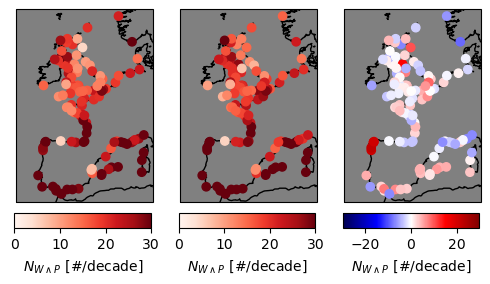

In [9]:
fig=plt.figure(figsize=(6,7.25)) #generate figure  
gs = fig.add_gridspec(2,3)


ax = plt.subplot(gs[0,0],projection=ccrs.Robinson(central_longitude=0))

ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='grey')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')


sc=ax.scatter(num_extremes_mem.lon,num_extremes_mem.lat,c=(.25*org.num_joint_extremes.sum(dim='month',skipna=False).sel(window=2000)),cmap='Reds',vmin=0,vmax=30,transform=ccrs.PlateCarree(),zorder=3)

ax.coastlines(zorder=1)
#sc=ax.scatter(n_wp_ds.lon,n_wp_ds.lat,c=.25*n_wp_ds_present.num_co_occurring.mean(dim='member_id').mean(dim='source_id'),cmap='Reds',vmin=0,vmax=30,s=20,transform=ccrs.PlateCarree(),zorder=3)
ax.set_extent([-13, 10, 35, 63], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$N_{W\wedge P}$ [#/decade]')


ax = plt.subplot(gs[0,1],projection=ccrs.Robinson(central_longitude=0))

ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='grey')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')


sc=ax.scatter(num_extremes_mem.lon,num_extremes_mem.lat,c=(.25*regridded.num_joint_extremes.sum(dim='month',skipna=False).sel(window=2000)),cmap='Reds',vmin=0,vmax=30,transform=ccrs.PlateCarree(),zorder=3)

ax.coastlines(zorder=1)
#sc=ax.scatter(n_wp_ds.lon,n_wp_ds.lat,c=.25*n_wp_ds_present.num_co_occurring.mean(dim='member_id').mean(dim='source_id'),cmap='Reds',vmin=0,vmax=30,s=20,transform=ccrs.PlateCarree(),zorder=3)
ax.set_extent([-13, 10, 35, 63], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$N_{W\wedge P}$ [#/decade]')


ax = plt.subplot(gs[0,2],projection=ccrs.Robinson(central_longitude=0))

ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='grey')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')


sc=ax.scatter(num_extremes_mem.lon,num_extremes_mem.lat,c=(.25*(regridded-org).num_joint_extremes.sum(dim='month',skipna=False).sel(window=2000)),cmap='seismic',vmin=-30,vmax=30,transform=ccrs.PlateCarree(),zorder=3)

ax.coastlines(zorder=1)
#sc=ax.scatter(n_wp_ds.lon,n_wp_ds.lat,c=.25*n_wp_ds_present.num_co_occurring.mean(dim='member_id').mean(dim='source_id'),cmap='Reds',vmin=0,vmax=30,s=20,transform=ccrs.PlateCarree(),zorder=3)
ax.set_extent([-13, 10, 35, 63], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$N_{W\wedge P}$ [#/decade]')

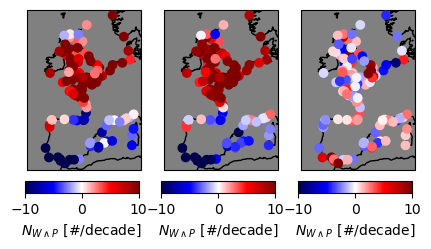

In [10]:
org_diff = (org.sum(dim='month',skipna=False).sel(window=2080)-org.sum(dim='month',skipna=False).sel(window=2000)).num_joint_extremes
regridded_diff = (regridded.sum(dim='month',skipna=False).sel(window=2080)-regridded.sum(dim='month',skipna=False).sel(window=2000)).num_joint_extremes

fig=plt.figure(figsize=(5,10)) #generate figure  
gs = fig.add_gridspec(2,3)


ax = plt.subplot(gs[0,0],projection=ccrs.Robinson(central_longitude=0))

ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='grey')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')


sc=ax.scatter(num_extremes_mem.lon,num_extremes_mem.lat,c=.25*org_diff,cmap='seismic',vmin=-10,vmax=10,transform=ccrs.PlateCarree(),zorder=3)

ax.coastlines(zorder=1)
#sc=ax.scatter(n_wp_ds.lon,n_wp_ds.lat,c=.25*n_wp_ds_present.num_co_occurring.mean(dim='member_id').mean(dim='source_id'),cmap='Reds',vmin=0,vmax=30,s=20,transform=ccrs.PlateCarree(),zorder=3)
ax.set_extent([-13, 10, 35, 63], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$N_{W\wedge P}$ [#/decade]')


ax = plt.subplot(gs[0,1],projection=ccrs.Robinson(central_longitude=0))

ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='grey')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')


sc=ax.scatter(num_extremes_mem.lon,num_extremes_mem.lat,c=.25*regridded_diff,cmap='seismic',vmin=-10,vmax=10,transform=ccrs.PlateCarree(),zorder=3)

ax.coastlines(zorder=1)
#sc=ax.scatter(n_wp_ds.lon,n_wp_ds.lat,c=.25*n_wp_ds_present.num_co_occurring.mean(dim='member_id').mean(dim='source_id'),cmap='Reds',vmin=0,vmax=30,s=20,transform=ccrs.PlateCarree(),zorder=3)
ax.set_extent([-13, 10, 35, 63], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$N_{W\wedge P}$ [#/decade]')


ax = plt.subplot(gs[0,2],projection=ccrs.Robinson(central_longitude=0))

ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='grey')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')


sc=ax.scatter(num_extremes_mem.lon,num_extremes_mem.lat,c=.25*(regridded_diff-org_diff),cmap='seismic',vmin=-10,vmax=10,transform=ccrs.PlateCarree(),zorder=3)

ax.coastlines(zorder=1)
#sc=ax.scatter(n_wp_ds.lon,n_wp_ds.lat,c=.25*n_wp_ds_present.num_co_occurring.mean(dim='member_id').mean(dim='source_id'),cmap='Reds',vmin=0,vmax=30,s=20,transform=ccrs.PlateCarree(),zorder=3)
ax.set_extent([-13, 10, 35, 63], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$N_{W\wedge P}$ [#/decade]')

In [20]:
(org.sum(dim='month',skipna=False).sel(window=2080)-org.sum(dim='month',skipna=False).sel(window=2000)).num_joint_extremes

<xarray.DataArray 'num_joint_extremes' (tg: 124)>
dask.array<sub, shape=(124,), dtype=float64, chunksize=(16,), chunktype=numpy.ndarray>
Coordinates:
    gridcell_lat  (tg) float64 dask.array<chunksize=(124,), meta=np.ndarray>
    gridcell_lon  (tg) float64 dask.array<chunksize=(124,), meta=np.ndarray>
    lat           (tg) float64 dask.array<chunksize=(124,), meta=np.ndarray>
    lon           (tg) float64 dask.array<chunksize=(124,), meta=np.ndarray>
    member_id     <U8 'r1i1p1f1'
  * tg            (tg) <U43 'arcachon_eyrac_.csv' ... 'maaloey_003_norway.csv'
    quantile      float64 0.98

In [16]:
regridded

<xarray.Dataset>
Dimensions:             (tg: 124, window: 7, month: 12)
Coordinates:
    member_id           <U8 'r1i1p1f1'
  * tg                  (tg) <U43 'arcachon_eyrac_.csv' ... 'maaloey_003_norw...
    gridcell_lat        (tg) float64 dask.array<chunksize=(124,), meta=np.ndarray>
    gridcell_lon        (tg) float64 dask.array<chunksize=(124,), meta=np.ndarray>
    lat                 (tg) float64 dask.array<chunksize=(124,), meta=np.ndarray>
    lon                 (tg) float64 dask.array<chunksize=(124,), meta=np.ndarray>
  * window              (window) int64 1960 1980 2000 2020 2040 2060 2080
    quantile            float64 0.98
  * month               (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    num_joint_extremes  (month, window, tg) float64 dask.array<chunksize=(12, 7, 16), meta=np.ndarray>
    num_surge_extremes  (month, window, tg) float64 dask.array<chunksize=(12, 7, 16), meta=np.ndarray>
    num_pr_extremes     (month, window, tg) float64 dask.array<chunksize=(12, 7, 124), meta=np.ndarray>

In [9]:
num_extremes_mem.num_joint_extremes.sel(window=1870).values

array([[2., 4., 0., ..., 3., 1., 4.],
       [1., 0., 0., ..., 0., 3., 2.],
       [0., 2., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 1., 0., 1.],
       [2., 0., 2., ..., 1., 1., 2.],
       [0., 1., 1., ..., 3., 1., 2.]])

In [19]:
surge_mri = xr.open_dataset('gs://leap-persistent/timh37/CMIP6/timeseries/surge_tgs/MRI-ESM2-0/MRI-ESM2-0_gn_day_ssp245.zarr',engine='zarr')

In [23]:
surge_mri.surge.isel(member_id=0).sel(tg='arcachon_eyrac_.csv').values[0:5]

array([-0.02292393,  0.10691351,  0.13449072,  0.35437461,  0.08488713])

In [17]:
fs.ls('gs://leap-persistent/timh37/CMIP6/timeseries/surge_tgs/MRI-ESM2-0/MRI-ESM2-0_gn_day_ssp245.zarr')

['leap-persistent/timh37/CMIP6/timeseries/surge_tgs/MRI-ESM2-0/MRI-ESM2-0_gn_day_ssp245.zarr',
 'leap-persistent/timh37/CMIP6/timeseries/surge_tgs/MRI-ESM2-0/MRI-ESM2-0_gn_day_ssp585.zarr']